# Setup: Import packages and load configuration

In [1]:
import json
import os
import numpy
import pandas
import copy
import conntility, connalysis

from scipy.spatial import KDTree
from pnagm import util, nngraph, instance, test

from matplotlib import pyplot as plt



## Loading data
Here, we load the data for our analysis. We begin by loading a configuration file that specifies which connectome to use as a reference and the parameters to use for the model approximating it. The configurations used in our manuscript are provided with this repository under /configs.

You can, of course, customize the configuration or create your own.

Then we load the connectome that is referenced in the configuration.

### Analysis parameters
Additionally, we set two parameters of this anlysis. Note they are not parameters of the connectome model. We simply parameterize how many stochastic instances to build and analyze and where to put the plots.

## Obtaining the reference connectome
Please note that the reference connectome must be separately downloaded. For the configuration files that are provided with this repository, we added comments to them that point you to the data repository where you can find them. Simply open the config file referenced in the first line below! 

Formally, the reference connectome must be in the .h5-based format used by [Connectome-utilities](https://github.com/openbraininstitute/ConnectomeUtilities).

In [2]:
config_fn = "../configs/pnagm_L45E_microns_yscale_experimental_v1p5.json"
n_instances = 5 
plot_out = "plots_sscx"
if not os.path.exists(plot_out):
    os.makedirs(plot_out)

with open(config_fn, "r") as fid:
    cfg = json.load(fid)

if "fn" in cfg["make_points"]:
    microns_fn = cfg["make_points"]["fn"]
    print("""
A reference connectome is expected at path {0},
          please place it there or update the path in the configuration file!
""".format(microns_fn))

pts, microns = util.points_from_microns(cfg["make_points"])
reference = microns.matrix > 0


A reference connectome is expected at path microns_mm3_connectome_v1181.h5,
          please place it there or update the path in the configuration file!

12881


## Building the model
Here, we build the specified number of instances of the model.
For convenience of analysis, we put their sparse adjacency matrices into a ConnectivityGroup object.

In [3]:
mdl_instances = []
mdls = []
for _ in range(n_instances):
    mdl_instance, M = util.create_neighbor_spread_graph(pts, cfg, reference=microns)
    print("Mean degree of neighbor graph: {0}".format(M.nnz / M.shape[0]))
    mdl_instances.append(mdl_instance)
    print("Mean degree of instance: {0}".format(mdl_instance.nnz / mdl_instance.shape[0]))
    mdl = conntility.ConnectivityMatrix(mdl_instance, vertex_properties=microns._vertex_properties)
    mdls.append(mdl)
mdls = conntility.ConnectivityGroup(pandas.DataFrame({"instance": range(n_instances)}),mdls)

Used custom weights!


/Users/danielaegas/repos/local_connectivity_model/src/pnagm/instance.py:26: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()


Mean degree of neighbor graph: 4.168853349895194
Mean degree of instance: 47.928732241285616
Used custom weights!


/Users/danielaegas/repos/local_connectivity_model/src/pnagm/instance.py:26: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()


Mean degree of neighbor graph: 4.140361773154258
Mean degree of instance: 48.05698315348187
Used custom weights!


/Users/danielaegas/repos/local_connectivity_model/src/pnagm/instance.py:26: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()


Mean degree of neighbor graph: 4.198587066221567
Mean degree of instance: 48.76197500194084
Used custom weights!


/Users/danielaegas/repos/local_connectivity_model/src/pnagm/instance.py:26: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()


Mean degree of neighbor graph: 4.136091918329322
Mean degree of instance: 48.59816784411148
Used custom weights!


/Users/danielaegas/repos/local_connectivity_model/src/pnagm/instance.py:26: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()


Mean degree of neighbor graph: 4.168620448722925
Mean degree of instance: 48.33949227544446


### Setting up the comparison tests and the distance-dependent control 

We start by loading precomputed Preferential attachment controls

In [4]:
path_PA = '/Users/danielaegas/Library/CloudStorage/OneDrive-OpenBrainInstitute/Shared Documents - OBI - Scientific staff/Data/microns_PA_fits/microns_PA_instance.h5'
ctrl_instances_PA = []
ctrls_PA = []
for i in range(n_instances):
    M = conntility.ConnectivityMatrix.from_h5(path_PA, group_name=f"instance_{i}")
    ctrl_instances_PA.append(M.matrix)
    ctrls_PA.append(M)
ctrls_PA = conntility.ConnectivityGroup(pandas.DataFrame({"instance": range(n_instances)}), ctrls_PA)


Here, we are bulding a "DDtest" object that serves as the basis for many of the tests comparing model to reference. Most tests are in some way distance-dependent, so this object stores a lot of information about all pairwise distances. Hence, it takes around 90 seconds to construct.

**Note that you only need to re-evaluate this cell when the reference data used changed. If you just want to adjust some parameters of the model, you do not need to re-run it!**

We also build some instances of a distance-dependent control here.


In [5]:
DD = test.DDtest(microns)

bin_centers = 0.5 * (test.dbins[1:] + test.dbins[:-1])

p = DD.for_matrix(reference)
logp = numpy.log(p)
valid = ~(numpy.isnan(logp) | numpy.isinf(logp))
f_params = numpy.polyfit(bin_centers[valid], logp[valid], 1)

a = numpy.exp(f_params[1])
b = -f_params[0]

ctrl_instances = []
ctrls = []
for _ in range(n_instances):
    ctrl_instance = connalysis.randomization.run_DD2(len(DD.m), a, b, DD.m.vertices[["x", "y", "z"]].values)
    ctrl_instances.append(ctrl_instance)
    ctrl = conntility.ConnectivityMatrix(ctrl_instance, vertex_properties=microns._vertex_properties)
    ctrls.append(ctrl)
ctrls = conntility.ConnectivityGroup(pandas.DataFrame({"instance": range(n_instances)}), ctrls)


/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:57: RuntimeWarning: invalid value encountered in divide
  return H / self.h_all
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:67: RuntimeWarning: invalid value encountered in divide
  return H / self.h_2d_all[ij]
/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/1388774208.py:6: RuntimeWarning: divide by zero encountered in log
  logp = numpy.log(p)


## Basic analyses

Here, we load a configuration file that references a number of simple analyses whose results can be summed up by a single number. We run it on reference, model and control.

In [6]:
with open("../configs/analysis_config.json", "r") as fid:
    analyses = json.load(fid)

def reciprocal_overexpression(m, pts):
    if m.nnz == 0:
        return numpy.nan
    mdl_coo = m.tocoo()
    edge_indices = pandas.DataFrame({"row": mdl_coo.row, "col": mdl_coo.col})
    e_rv = edge_indices.reset_index(drop=True).rename(columns={"row": "col", "col": "row"})[["row", "col"]]
    e = pandas.concat([e_rv, edge_indices.reset_index(drop=True)], axis=0)
    vc = e.drop_duplicates(keep="last").index.value_counts()
    count_rc = (vc == 1).sum()
    count_all = len(edge_indices)
    n_pairs = mdl_coo.shape[0] * (mdl_coo.shape[1] - 1)
    return (count_rc / n_pairs) / ((count_all / n_pairs) ** 2)

analyses["analyses"]["rec_overexpression"] = {
    "source": reciprocal_overexpression,
    "output": "Value"
}

pandas.concat([
    pandas.Series(microns.analyze(analyses)),
    pandas.DataFrame(mdls.analyze(analyses)).transpose(),
    pandas.DataFrame(ctrls.analyze(analyses)).transpose(),
    pandas.DataFrame(ctrls_PA.analyze(analyses)).transpose()
], axis=1, keys=["reference", "model", "DD", "PA"], names=["Data source"])

Data source             reference          model                 \
                                0           (0,)           (1,)   
skewness_aff             1.870087       1.015174       1.106018   
nnz                 616553.000000  617370.000000  619022.000000   
con_prob                 0.037733       0.041933       0.042032   
cn_bias_eff             13.569980      11.984850      11.844765   
skewness_eff             5.825877       1.732883       1.783088   
rec_overexpression       8.178887       7.123015       6.981135   
cn_bias_aff              6.261806      12.516601      12.453950   
mean_degree             47.865305      47.928732      48.056983   

Data source                                                      \
                             (2,)           (3,)           (4,)   
skewness_aff             1.033457       1.053630       1.010306   
nnz                 628103.000000  625993.000000  622661.000000   
con_prob                 0.041915       0.042293       0.042244   
cn_bias_eff             11.585297      11.687405      11.831350   
skewness_eff             1.754575       1.765243       1.778567   
rec_overexpression       6.747929       6.825672       6.904910   
cn_bias_aff             12.041568      12.195640      12.208461   
mean_degree             48.761975      48.598168      48.339492   

Data source                    DD                                \
                             (0,)           (1,)           (2,)   
skewness_aff            -0.092664      -0.095707      -0.089331   
nnz                 548144.000000  550133.000000  548708.000000   
con_prob                 0.041142       0.041374       0.041156   
cn_bias_eff              3.518035       3.510807       3.511299   
skewness_eff            -0.077557      -0.076659      -0.080355   
rec_overexpression       6.152325       5.856848       6.021761   
cn_bias_aff              3.516804       3.509024       3.511234   
mean_degree             42.554460      42.708874      42.598245   

Data source                                                  PA  \
                             (3,)           (4,)           (0,)   
skewness_aff            -0.084924      -0.100465       5.487082   
nnz                 549055.000000  550312.000000  612506.000000   
con_prob                 0.041232       0.041298       0.003701   
cn_bias_eff              3.516658       3.512150       3.781335   
skewness_eff            -0.075747      -0.098538       5.523149   
rec_overexpression       5.938205       5.914395       8.232488   
cn_bias_aff              3.516925       3.516843       3.777761   
mean_degree             42.625184      42.722770      47.551122   

Data source                                                                     
                             (1,)           (2,)           (3,)           (4,)  
skewness_aff             5.689002       5.666673       5.552888       5.611090  
nnz                 612506.000000  612506.000000  612506.000000  612506.000000  
con_prob                 0.003678       0.003703       0.003739       0.003647  
cn_bias_eff              3.826056       3.818603       3.775315       3.807016  
skewness_eff             5.746563       5.646692       5.511991       5.599905  
rec_overexpression       8.232488       8.232488       8.232488       8.232488  
cn_bias_aff              3.828261       3.806311       3.800301       3.812868  
mean_degree             47.551122      47.551122      47.551122      47.551122

### Plot: Degree distributions

/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fit_res.append(Hs.applymap(fit_log_distribution))
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:86: RuntimeWarning: divide by zero encountered in log10
  logx = numpy.log10(x)
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fit_res.append(Hs.applymap(fit_log_distribution))
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:86: RuntimeWarning: divide by zero encountered in log10
  logx = numpy.log10(x)


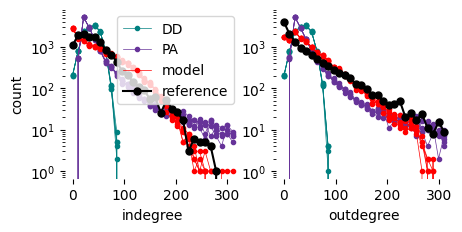

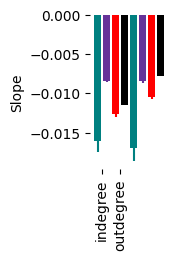

In [7]:
fig_distr, fig_slopes = DD.degree_distribution_analysis([mdls, ctrls, ctrls_PA], ["model", "DD", "PA"])
fig_distr.savefig(os.path.join(plot_out, "m_degree_distributions.pdf"))
fig_slopes.savefig(os.path.join(plot_out, "m_degrees_slopes.pdf"))


### Plot: two-d distance dependence of connectivity

/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:67: RuntimeWarning: invalid value encountered in divide
  return H / self.h_2d_all[ij]
/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/2769650255.py:8: RuntimeWarning: Mean of empty slice
  numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/2769650255.py:10: RuntimeWarning: Mean of empty slice
  numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/2769650255.py:12: RuntimeWarning: Mean of empty slice
  numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))


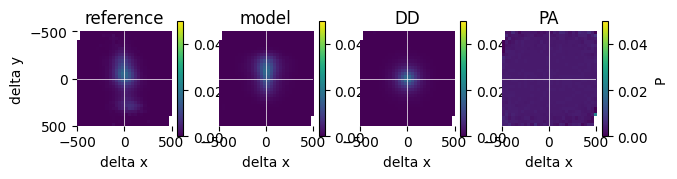

In [8]:
from matplotlib import pyplot as plt
from pnagm.test import dbins2d

clim = (0, 0.05)
fig = plt.figure(figsize=(7, 1.5))

Is = [DD.p_2d_ref[(1, 2)],
     numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
                                 for _instance in mdl_instances]), axis=2),
     numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
                                     for _instance in ctrl_instances]), axis=2),                            
     numpy.nanmean(numpy.dstack([DD.twod_for_matrix(_instance, (1, 2))
                                     for _instance in ctrl_instances_PA]), axis=2)                            
    ]
ttls = ["reference", "model", "DD", "PA"]
i = 1

for I, ttl in zip(Is, ttls):
    ax = fig.add_subplot(1, 4, i)
    if i > 1:
        ax.set_yticks([])
    else:
        ax.set_ylabel("delta y")
    i += 1
    img = ax.imshow(I, clim=clim,
            extent=[dbins2d[0], dbins2d[-1], dbins2d[-1], dbins2d[0]])
    plt.colorbar(img, label="P")
    ax.set_xlim(ax.get_xlim()); ax.set_ylim(ax.get_ylim())
    ax.plot(ax.get_xlim(), [0, 0], color="white", linewidth=0.5)
    ax.plot([0, 0], ax.get_xlim(), color="white", linewidth=0.5)
    ax.set_frame_on(False)
    ax.set_xlabel("delta x")
    ax.set_title(ttl)

fig.savefig(os.path.join(plot_out, "m_2d_distance_dependence.pdf"))


### Plot: Percentage of downwards facing connections

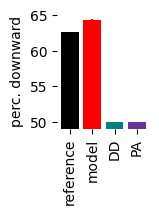

In [9]:
def percent_downwards(instance):
    dy = numpy.diff(instance.edge_associated_vertex_properties("y"), axis=1)
    return 100 * numpy.mean(dy > 0)

ref = percent_downwards(microns)
v_mdl = [percent_downwards(mdls[i]) for i in mdls.index]
v_ctrl = [percent_downwards(ctrls[i]) for i in ctrls.index]
v_ctrl_PA = [percent_downwards(ctrls_PA[i]) for i in ctrls_PA.index]

fig = plt.figure(figsize=(1.2, 1.5))
ax = fig.gca()

bot = 49.0

ax.bar(0, ref - bot, color="black", bottom=bot)
ax.bar(1, numpy.mean(v_mdl) - bot, color="red", bottom=bot)
ax.errorbar(1, numpy.mean(v_mdl), yerr=numpy.std(v_mdl), color="red")
ax.bar(2, numpy.mean(v_ctrl) - bot, color="teal", bottom=bot)
ax.errorbar(2, numpy.mean(v_ctrl), yerr=numpy.std(v_ctrl), color="teal")
ax.bar(3, numpy.mean(v_ctrl_PA) - bot, color="rebeccapurple", bottom=bot)
ax.errorbar(3, numpy.mean(v_ctrl_PA), yerr=numpy.std(v_ctrl_PA), color="rebeccapurple")
ax.set_ylabel("perc. downward")
ax.set_xticks([0, 1, 2, 3]); ax.set_xticklabels(["reference", "model", "DD", "PA"], rotation="vertical")
ax.set_frame_on(False)

fig.savefig(os.path.join(plot_out, "m_perc_down.pdf"))


### Plot: one-d distance-dependence of connectivity

/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:57: RuntimeWarning: invalid value encountered in divide
  return H / self.h_all


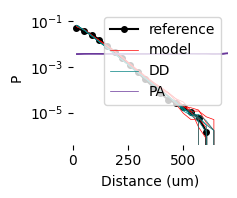

In [10]:
from matplotlib import pyplot as plt
from pnagm import test

bin_centers = 0.5 * (test.dbins[1:] + test.dbins[:-1])

fig = plt.figure(figsize=(2., 1.75))
ax = fig.gca()

ax.plot(bin_centers, DD.p_ref, color="black", lw=1.5, marker="o", ms=4, label="reference")
for i, _instance in enumerate(mdl_instances):
    lbl = None
    if i == 0: lbl = "model"
    ax.plot(bin_centers, DD.for_matrix(_instance), label=lbl, color="red", lw=0.5)
for i, _instance in enumerate(ctrl_instances):
    lbl = None
    if i == 0: lbl = "DD"
    ax.plot(bin_centers, DD.for_matrix(_instance), label=lbl, color="teal", lw=0.5)
for i, _instance in enumerate(ctrl_instances_PA):
    lbl = None
    if i == 0: lbl = "PA"
    ax.plot(bin_centers, DD.for_matrix(_instance), label=lbl, color="rebeccapurple", lw=0.5)

ax.set_yscale("log")
ax.set_xlim([0, 700])
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
plt.legend()

fig.savefig(os.path.join(plot_out, "m_1d_distance_dependence.pdf"))

### Plot: Nearest neighbor interaction
This plot contrasts the overall connection probability at various distances to the connection probability conditional on the nearest neighbor being connected. If the two are different it proves a statistical dependence between the two potential edges.

/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:184: RuntimeWarning: invalid value encountered in divide
  ret = H_x_con / H_x_all  # Probability that a neuron with connected NN is connected itself (per dist bin)
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:57: RuntimeWarning: invalid value encountered in divide
  return H / self.h_all


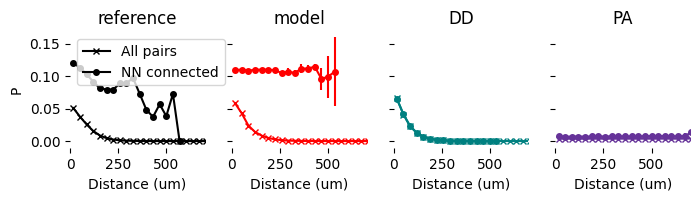

In [11]:
fig = plt.figure(figsize=(8, 1.5))
axes = fig.subplots(1, 4, sharey=True)
xlim = [0, 700]

ax = axes[0]
ax.plot(bin_centers, DD.p_ref, color="black", marker='x', lw=1.5, ms=4, label="All pairs")
ax.plot(bin_centers, DD.dist_and_nn_analysis(DD.m.matrix), color="black", marker='o', lw=1.5, ms=4, label="NN connected")
ax.set_ylabel("P")
ax.set_xlim(xlim)
ax.legend()
ax.set_title("reference")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

ax = axes[1]
p_basics = numpy.vstack([DD.for_matrix(_instance) for _instance in mdl_instances])
p_nn_con = numpy.vstack([DD.dist_and_nn_analysis(_instance) for _instance in mdl_instances])
ax.plot(bin_centers, numpy.mean(p_basics, axis=0), color="red", marker='x', lw=1.5, ms=4)
ax.errorbar(bin_centers, numpy.mean(p_nn_con, axis=0), yerr=numpy.std(p_nn_con, axis=0),
             color="red", marker='o', lw=1.5, ms=4)
ax.set_xlim(xlim)
ax.set_title("model")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

ax = axes[2]
p_basics = numpy.vstack([DD.for_matrix(_instance) for _instance in ctrl_instances])
p_nn_con = numpy.vstack([DD.dist_and_nn_analysis(_instance) for _instance in ctrl_instances])
ax.plot(bin_centers, numpy.mean(p_basics, axis=0), color="teal", marker='x', lw=1.5, ms=4)
ax.errorbar(bin_centers, numpy.mean(p_nn_con, axis=0), yerr=numpy.std(p_nn_con, axis=0),
             color="teal", marker='o', lw=1.5, ms=4)
ax.set_xlim(xlim)
ax.set_title("DD")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

ax = axes[3]
p_basics = numpy.vstack([DD.for_matrix(_instance) for _instance in ctrl_instances_PA])
p_nn_con = numpy.vstack([DD.dist_and_nn_analysis(_instance) for _instance in ctrl_instances_PA])
ax.plot(bin_centers, numpy.mean(p_basics, axis=0), color="rebeccapurple", marker='x', lw=1.5, ms=4)
ax.errorbar(bin_centers, numpy.mean(p_nn_con, axis=0), yerr=numpy.std(p_nn_con, axis=0),
             color="rebeccapurple", marker='o', lw=1.5, ms=4)
ax.set_xlim(xlim)
ax.set_title("PA")
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")

fig.savefig(os.path.join(plot_out, "m_distance_and_nn_analysis.pdf"))



### Plot: Simplex counts

[2025-07-31 18:23:09,082] WARNING: No seed among keyword arguments
[2025-07-31 18:23:13,158] WARNING: No seed among keyword arguments
[2025-07-31 18:23:17,003] WARNING: No seed among keyword arguments
[2025-07-31 18:23:20,864] WARNING: No seed among keyword arguments
[2025-07-31 18:23:24,758] WARNING: No seed among keyword arguments
[2025-07-31 18:23:28,614] WARNING: No seed among keyword arguments
[2025-07-31 18:23:32,466] WARNING: No seed among keyword arguments
[2025-07-31 18:23:36,184] WARNING: No seed among keyword arguments
[2025-07-31 18:23:39,930] WARNING: No seed among keyword arguments
[2025-07-31 18:23:43,776] WARNING: No seed among keyword arguments
[2025-07-31 18:23:47,474] WARNING: No seed among keyword arguments
[2025-07-31 18:23:51,197] WARNING: No seed among keyword arguments
[2025-07-31 18:23:55,105] WARNING: No seed among keyword arguments
[2025-07-31 18:23:58,995] WARNING: No seed among keyword arguments
[2025-07-31 18:24:02,924] WARNING: No seed among keyword argum

/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/danielaegas/repos/local_connectivity_model/src/pnagm/test.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


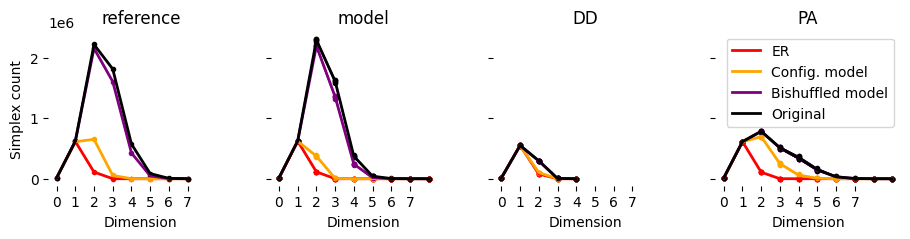

In [12]:
def simplex_counts_over_instances(instances):
    all_smplx_model = pandas.concat([
        test.DDtest.simplex_counts_and_controls(_instance)
        for _instance in instances
    ], axis=1, names=["instance"], keys=range(len(instances)))
    return all_smplx_model

src_instances = [mdl_instances, ctrl_instances, ctrl_instances_PA]
src_labels = ["model", "DD", "PA"]

fig = DD.simplex_count_analysis(src_instances, src_labels)

fig.savefig(os.path.join(plot_out, "m_simplex_analysis.pdf"))


### Plot: Pathway-specific connection probabilities

[[1.         0.71088856]
 [0.71088856 1.        ]]


/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/946567911.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/946567911.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(j, i, marker=mrk_pre, c=col_post)


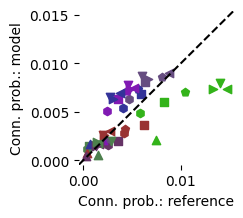

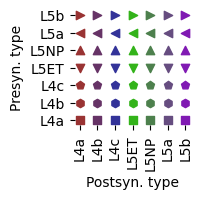

In [13]:
col = "cell_type"
#col = "mtype"

c = DD.m.vertices[col].value_counts().sort_index()
nrml = c.values.reshape((-1, 1)) * c.values.reshape((1, -1))

p_ref = DD.m.condense(col).array / nrml
mrks = {
    "L4a": "s",
    "L4b": "h",
    "L4c": "p",
    "L5ET": "v",
    "L5NP": "^",
    "L5a": "<",
    "L5b": ">",
    "L2a": "s",
    "L2b": "h",
    "L2c": "p",
    "L3a": "v",
    "L3b": "^",
    "L4_TPC": "s",
    "L5_TPC:A": "<",
    "L5_TPC:B": ">",
    "L4_SSC": "h",
    "L5_UPC": "^",
    "L5_TPC:C": "v"
}
cols = {
    "L4a": [0.6, 0.2, 0.2],
    "L4b": [0.4, 0.2, 0.4],
    "L4c": [0.2, 0.2, 0.6],
    "L5ET": [0.2, 0.7, 0.1],
    "L5NP": [0.3, 0.5, 0.3],
    "L5a": [0.4, 0.3, 0.5],
    "L5b": [0.5, 0.1, 0.7],
    "L2a": [0.6, 0.2, 0.2],
    "L2b": [0.4, 0.2, 0.4],
    "L2c": [0.2, 0.2, 0.6],
    "L3a": [0.2, 0.7, 0.1],
    "L3b": [0.3, 0.5, 0.3],
    "L4_TPC": [0.6, 0.2, 0.2],
    "L5_TPC:A": [0.4, 0.3, 0.5],
    "L5_TPC:B": [0.5, 0.1, 0.7],
    "L4_SSC": [0.4, 0.2, 0.4],
    "L5_UPC": [0.3, 0.5, 0.3],
    "L5_TPC:C": [0.2, 0.7, 0.1]
}
p_mdls = numpy.dstack([mdls[i].condense(col).array / nrml
                       for i in mdls.index])

fig = plt.figure(figsize=(2, 2))
fig2 = plt.figure(figsize=(1.5, 1.5))
ax = fig.gca()
ax2 = fig2.gca()

for i, pre in enumerate(c.index.values):
    mrk_pre = mrks[pre]
    for j, post in enumerate(c.index.values):
        col_post = cols[post]
        v_x = p_ref[i, j]
        v_ys = p_mdls[i, j, :]
        v_y = numpy.mean(v_ys)
        ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
        ax2.scatter(j, i, marker=mrk_pre, c=col_post)
ax.set_frame_on(False)
lims = numpy.vstack([ax.get_xlim(), ax.get_ylim()])
lims = [lims[:, 0].min(), lims[:, 1].max()]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(ax.get_xlim(), ax.get_xlim(), color="black", ls="--")
ax.set_xlabel("Conn. prob.: reference")
ax.set_ylabel("Conn. prob.: model")

ax2.set_xticks(range(len(c.index)))
ax2.set_yticks(range(len(c.index)))
ax2.set_xticklabels(c.index, rotation="vertical")
ax2.set_yticklabels(c.index)
ax2.set_xlabel("Postsyn. type")
ax2.set_ylabel("Presyn. type")
ax2.set_frame_on(False)


print(numpy.corrcoef(p_ref.flatten(), p_mdls.mean(axis=2).flatten()))
fig.savefig(os.path.join(plot_out, "m_pathway_con_probs_model.pdf"))
fig2.savefig(os.path.join(plot_out, "m_pathway_con_probs_legend.pdf"))

[[1.         0.49473377]
 [0.49473377 1.        ]]


/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/1124827655.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
/var/folders/2y/n0mhzyls0yb3sz082xd12clc0000gn/T/ipykernel_7612/1124827655.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(j, i, marker=mrk_pre, c=col_post)


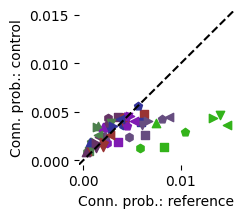

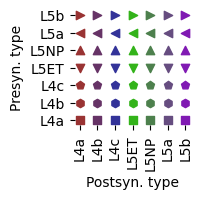

In [14]:
clim = [0, 0.01]

c = DD.m.vertices[col].value_counts().sort_index()
nrml = c.values.reshape((-1, 1)) * c.values.reshape((1, -1))

p_ref = DD.m.condense(col).array / nrml

p_mdls = numpy.dstack([ctrls[i].condense(col).array / nrml
                       for i in ctrls.index])

fig = plt.figure(figsize=(2, 2))
fig2 = plt.figure(figsize=(1.5, 1.5))
ax = fig.gca()
ax2 = fig2.gca()

for i, pre in enumerate(c.index.values):
    mrk_pre = mrks[pre]
    for j, post in enumerate(c.index.values):
        col_post = cols[post]
        v_x = p_ref[i, j]
        v_ys = p_mdls[i, j, :]
        v_y = numpy.mean(v_ys)
        ax.scatter(v_x, v_y, marker=mrk_pre, c=col_post)
        ax2.scatter(j, i, marker=mrk_pre, c=col_post)
ax.set_frame_on(False)
lims = numpy.vstack([ax.get_xlim(), ax.get_ylim()])
lims = [lims[:, 0].min(), lims[:, 1].max()]
ax.set_xlim(lims); ax.set_ylim(lims)
ax.plot(ax.get_xlim(), ax.get_xlim(), color="black", ls="--")
ax.set_xlabel("Conn. prob.: reference")
ax.set_ylabel("Conn. prob.: control")

ax2.set_xticks(range(len(c.index)))
ax2.set_yticks(range(len(c.index)))
ax2.set_xticklabels(c.index, rotation="vertical")
ax2.set_yticklabels(c.index)
ax2.set_xlabel("Postsyn. type")
ax2.set_ylabel("Presyn. type")
ax2.set_frame_on(False)


print(numpy.corrcoef(p_ref.flatten(), p_mdls.mean(axis=2).flatten()))
fig.savefig(os.path.join(plot_out, "m_pathway_con_probs_control.pdf"))